# 📰 Reddit TIFU Summarization with BART  
**Fine‑tuning a seq2seq model to generate concise summaries of “Today I F***ed Up” posts**  

This notebook walks through loading the dataset, preprocessing, training a BART model, evaluating with ROUGE, and generating example summaries.


## 📋 Table of Contents
1. [Setup & Imports](#setup)  
2. [Dataset Loading & Exploration](#exploration)  
3. [Preprocessing](#preprocessing)  
4. [Model & Training](#training)  
5. [Evaluation](#evaluation)  
6. [Inference Examples](#inference)  
7. [Next Steps & Resources](#next-steps)


## <a name="setup"></a>1. Setup & Imports  
Install packages and import libraries.


In [ ]:
!pip install datasets transformers evaluate rouge_score --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires

In [ ]:
!pip install --upgrade transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 70.5 MB/s eta 0:00:00


## <a name="exploration"></a>2. Dataset Loading & Exploration  
- Load the Reddit TIFU dataset  
- Peek at a few examples  
- Basic statistics (number of posts, average length)


In [ ]:
from datasets import load_dataset

dataset = load_dataset("reddit_tifu", "long")
dataset = dataset['train'].train_test_split(test_size=0.1, seed=42)
print(dataset)


README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

reddit_tifu.py:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

The repository for reddit_tifu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/reddit_tifu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


tifu_all_tokenized_and_filtered.json.gz:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42139 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 37925
    })
    test: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 4214
    })
})


Document Stats:
 count    37925.000000
mean       386.483401
std        283.973982
min          1.000000
25%        207.000000
50%        314.000000
75%        479.000000
max       6004.000000
Name: doc_len, dtype: float64

Summary Stats:
 count    37925.000000
mean        20.606328
std         12.926637
min          1.000000
25%         12.000000
50%         18.000000
75%         26.000000
max        420.000000
Name: tldr_len, dtype: float64


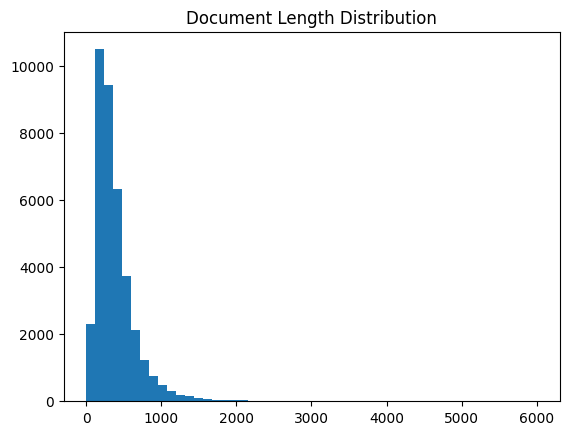

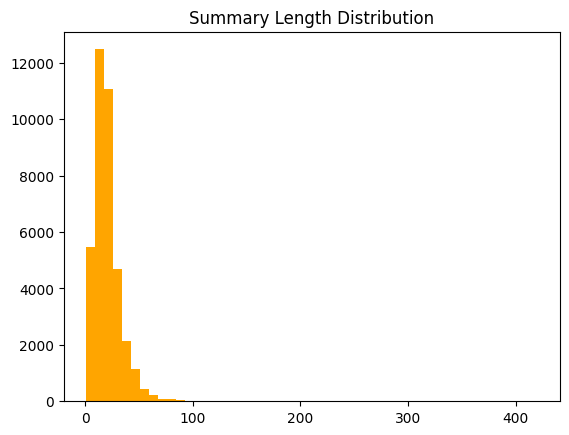

In [ ]:
import pandas as pd

df = dataset['train'].to_pandas()
df['doc_len'] = df['documents'].apply(lambda x: len(x.split()))
df['tldr_len'] = df['tldr'].apply(lambda x: len(x.split()))

print("Document Stats:\n", df['doc_len'].describe())
print("\nSummary Stats:\n", df['tldr_len'].describe())

import matplotlib.pyplot as plt

plt.hist(df['doc_len'], bins=50)
plt.title('Document Length Distribution')
plt.show()

plt.hist(df['tldr_len'], bins=50, color='orange')
plt.title('Summary Length Distribution')
plt.show()

## <a name="preprocessing"></a>3. Preprocessing  
- Define tokenizer and max lengths  
- Tokenize train & validation splits  
- Create PyTorch/TF dataloaders


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_input_length = 512
max_target_length = 64

def preprocess_function(examples):
    inputs = examples["documents"]
    targets = examples["tldr"]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/37925 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in result.items()}


## <a name="training"></a>4. Model & Training  
- Load pretrained BART model  
- Configure training hyperparameters  
- Kick off training loop  


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-finetuned-reddit-tifu",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir='./logs',
    save_total_limit=2,
    predict_with_generate=True,
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


<ipython-input-10-a37a4bdce043>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hmankar01 (hmankar01-new-jersey-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,3.404700
1000,3.253000
1500,3.206000
2000,3.168500
2500,3.143900
3000,3.114000
3500,3.106700
4000,3.070300
4500,3.063500
5000,2.990000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=14223, training_loss=2.934957726749532, metrics={'train_runtime': 8793.9557, 'train_samples_per_second': 12.938, 'train_steps_per_second': 1.617, 'total_flos': 3.454429035552768e+16, 'train_loss': 2.934957726749532, 'epoch': 3.0})

## <a name="inference"></a>6. Inference Examples  
Generate a few sample summaries to see the model in action.


In [ ]:
def summarize(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    summary_ids = model.generate(**inputs, max_length=64, num_beams=4, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example
print(summarize("Today I woke up late and got late to work and then I slipped on the footpath and spilled my coffee all over me and ruined my white hoodie soo my day was really shitty."))


i slipped on the footpath and spilled coffee all over myself and ruined my white hoodie


## <a name="next-steps"></a>7. Next Steps & Resources  
- Push model to Hugging Face Hub  
- Experiment with different max_length/min_length  
- Try beam search vs. sampling  
- References & further reading
